#### Convert Metadata to COCO Format

In [1]:
import json
import os

####### Convert Meta Data to COCO #######

CATEGORIES = {
    'certain whale': 1,
    'uncertain whale': 2,
    'harp seal': 3
}

def convert_metadata_to_coco(metadata_path, coco_path, crop_size):
    # Load the metadata
    with open(metadata_path, 'r') as json_file:
        metadata = json.load(json_file)

    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "certain whale"},
            {"id": 2, "name": "uncertain whale"},
            {"id": 3, "name": "harp seal"}
        ]
    }

    annotation_id = 1
    image_id = 1
    for tile in metadata['tiles']:
        for window in tile['windows']:
            file_name_tif = window['dataURL']
            image_info = {
                "id": image_id,
                "file_name": file_name_tif[:-4]+'.png',
                "height": crop_size,  # 需要根据实际图像高度更新
                "width": crop_size   # 需要根据实际图像宽度更新
            }
            # coco_data["images"].append(image_info)
            image_append_flag = True
            
            for label in window['labels']:
                if label['class'] in CATEGORIES:
                    if image_append_flag:
                        coco_data["images"].append(image_info)
                        image_append_flag = False
                    if 'bbox' not in label:
                        print(f"No bbox found for label {label} in {window['dataURL']}")
                        continue
                    bbox = label['bbox']
                    annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": CATEGORIES[label['class']],
                        "bbox": bbox,
                        "area": bbox[2] * bbox[3],
                        "segmentation": [],
                        "iscrowd": 0
                    }
                    coco_data["annotations"].append(annotation)
                    annotation_id += 1
            image_id += 1

    # Save COCO annotations to file
    with open(coco_path, 'w') as coco_file:
        json.dump(coco_data, coco_file, indent=4)
    print(f'Saved COCO annotations to {coco_path}')
    

####### Merge #######
def load_coco_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def merge_coco_files(output_path, *file_paths):
    file_paths = file_paths

    merged_coco = {
        "images": [],
        "annotations": []
    }

    image_id_mapping = {}
    new_image_id = 1
    new_annotation_id = 1

    for file_path in file_paths:
        coco = load_coco_file(file_path)

        for image in coco["images"]:
            new_image_info = image.copy()
            image_id_mapping[image["id"]] = new_image_id
            new_image_info["id"] = new_image_id
            merged_coco["images"].append(new_image_info)
            new_image_id += 1

        for annotation in coco["annotations"]:
            new_annotation = annotation.copy()
            new_annotation["id"] = new_annotation_id
            new_annotation["image_id"] = image_id_mapping[annotation["image_id"]]
            merged_coco["annotations"].append(new_annotation)
            new_annotation_id += 1

    merged_coco["categories"] = coco["categories"]
    
    with open(output_path, 'w') as output_file:
        json.dump(merged_coco, output_file, indent=4)

    print(f"Saved merged COCO annotations to {output_path}")
    
    
####### Split #######
def split_coco_annotations(ref_split_dir, src_coco, target_split_dir):
    """
    Splits a COCO annotation file into train, val, and test based on reference splits.

    Args:
        ref_split_dir (str): Directory containing reference split JSON files (train.json, val.json, test.json).
        src_coco (str): Path to the source COCO annotation file.
        target_split_dir (str): Directory to save the split COCO annotation files.
    """
    # Ensure target directory exists
    os.makedirs(target_split_dir, exist_ok=True)

    # Load source COCO annotations
    with open(src_coco, 'r') as f:
        src_coco_data = json.load(f)

    # Build mappings for images and annotations
    src_images = {img['file_name']: img for img in src_coco_data['images']}
    annotations_by_image_id = {}
    for ann in src_coco_data['annotations']:
        if ann['image_id'] not in annotations_by_image_id:
            annotations_by_image_id[ann['image_id']] = []
        annotations_by_image_id[ann['image_id']].append(ann)

    # Process each split (train, val, test)
    for split in ['train', 'val', 'test']:
        ref_split_path = os.path.join(ref_split_dir, f'{split}.json')
        target_split_path = os.path.join(target_split_dir, f'{split}.json')

        # Load reference split
        with open(ref_split_path, 'r') as f:
            ref_split_data = json.load(f)

        # Prepare target split structure
        target_split_data = {
            "info": src_coco_data.get("info", {}),
            "licenses": src_coco_data.get("licenses", []),
            "categories": src_coco_data["categories"],
            "images": [],
            "annotations": []
        }

        # Populate images and annotations
        for ref_image in ref_split_data['images']:
            file_name = ref_image['file_name']
            if file_name in src_images:
                # Add image to target split
                image_data = src_images[file_name]
                target_split_data['images'].append(image_data)

                # Add associated annotations
                image_id = image_data['id']
                if image_id in annotations_by_image_id:
                    target_split_data['annotations'].extend(annotations_by_image_id[image_id])

        # Save the split
        with open(target_split_path, 'w') as f:
            
            json.dump(target_split_data, f, indent=4)

        print(f"Saved {split} split to {target_split_path}")

#### Convert, Merge, and Split

In [3]:
# Update these paths as needed
metadata_path_1 = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/metadata_crops_Churchill_320_BUF_7.json'
metadata_path_2 = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/metadata_crops_CW21_320_BUF_7.json'
metadata_path_3 = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/metadata_crops_CW22_192_BUF_7.json'
coco_path_1 = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_sam_Churchill_320_BUF_7.json'
coco_path_2 = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_sam_CW21_320_BUF_7.json'
coco_path_3 = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_sam_CW22_192.json'
crop_size_1, crop_size_2, crop_size_3 = 320, 320, 192
# Convert metadata to COCO format
convert_metadata_to_coco(metadata_path_1, coco_path_1, crop_size=crop_size_1)
convert_metadata_to_coco(metadata_path_2, coco_path_2, crop_size=crop_size_2)
convert_metadata_to_coco(metadata_path_3, coco_path_3, crop_size=crop_size_3)

Saved COCO annotations to /data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_sam_Churchill_320_BUF_7.json
Saved COCO annotations to /data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_sam_CW21_320_BUF_7.json
Saved COCO annotations to /data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_sam_CW22_192.json


In [4]:
# Merge the COCO files
coco_path_merged = r'/data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_anns_sam_BUF_7.json'
merge_coco_files(coco_path_merged, coco_path_1, coco_path_2, coco_path_3)

Saved merged COCO annotations to /data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_anns_sam_BUF_7.json


In [6]:
# Split coco annotations into train, val, test
src_coco = coco_path_merged
target_split_dir = '/data1/zhengyj/mmyolo/datasets/beluga/annotations/split_sam_BUF_7'
ref_split_dir = '/data1/zhengyj/mmyolo/datasets/beluga/annotations/split_box_BUF_7'

split_coco_annotations(ref_split_dir, src_coco, target_split_dir)

Saved train split to /data1/zhengyj/mmyolo/datasets/beluga/annotations/split_sam_BUF_7/train.json
Saved val split to /data1/zhengyj/mmyolo/datasets/beluga/annotations/split_sam_BUF_7/val.json
Saved test split to /data1/zhengyj/mmyolo/datasets/beluga/annotations/split_sam_BUF_7/test.json


#### Check split consistency

In [7]:
# Load the COCO annotations from the two JSON files
def load_coco_annotations(coco_ann_path):
    with open(coco_ann_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Extract image IDs or file names from the annotations
def extract_image_ids(annotations):
    return {image['id']: image['file_name'] for image in annotations['images']}

# Compare the images in the two annotations
def compare_annotations(coco_ann_1, coco_ann_2):
    # Load the annotations
    annotations_1 = load_coco_annotations(coco_ann_1)
    annotations_2 = load_coco_annotations(coco_ann_2)

    # Extract image IDs
    images_1 = extract_image_ids(annotations_1)
    images_2 = extract_image_ids(annotations_2)

    # Compare the image IDs
    same_images = set(images_1.keys()).intersection(set(images_2.keys()))
    only_in_ann_1 = set(images_1.keys()) - set(images_2.keys())
    only_in_ann_2 = set(images_2.keys()) - set(images_1.keys())

    return same_images, only_in_ann_1, only_in_ann_2

# File paths to the COCO annotations
coco_ann_1 = '/data1/zhengyj/mmyolo/datasets/beluga/annotations/split_sam_BUF_7/train.json'
coco_ann_2 = '/data1/zhengyj/mmyolo/datasets/beluga/annotations/split_box_BUF_6/train.json'

# Perform the comparison
same_images, only_in_ann_1, only_in_ann_2 = compare_annotations(coco_ann_1, coco_ann_2)

# Print the results
print(f"Common images: {len(same_images)}")
print(f"Images only in annotation 1: {len(only_in_ann_1)}")
print(f"Images only in annotation 2: {len(only_in_ann_2)}")

Common images: 378
Images only in annotation 1: 0
Images only in annotation 2: 0


#### Visualize

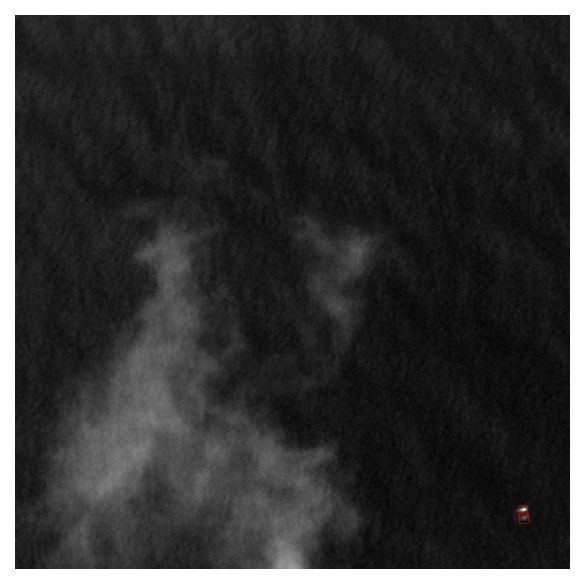

In [2]:
import json
import os
import matplotlib.pyplot as plt
import cv2

# Paths
img_dir = '/data1/zhengyj/mmyolo/datasets/beluga/images'
ann_path = '/data1/zhengyj/mmyolo/datasets/beluga/annotations/coco_bbox_Churchill_413.json'
ann_path2 = './configs'
img_file_name = '22JUL31174054-P3DS_R2C2-050169967010_01_P001_24_16.png'  # Replace with your image filename
with open(ann_path, 'r') as f:
    annotation = json.load(f)

name2annid = {}
for image in annotation['images']:
    ann_id = []
    for i, ann in enumerate(annotation['annotations']):
        if ann['image_id'] == image['id']:
            ann_id.append(i)
    name2annid[image['file_name']] = ann_id
    
def get_gt_box(file_name):
    bboxes = [annotation['annotations'][i]['bbox'] for i in name2annid[file_name]]

    return bboxes

import matplotlib.patches as patches

def draw_bbox(img, bboxes, confidences=None, dpi=150):
    fig, ax = plt.subplots(1, dpi=dpi)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)

    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=0.5, edgecolor='r', facecolor='none', alpha=0.5)
        ax.add_patch(rect)
        
        if confidences is not None and i < len(confidences):
            print(confidences)
            confidence_text = f'{confidences[i]:.2f}'
            ax.text(rect.xy[0]-1.3, rect.xy[1] - 1.5, confidence_text,
                        va='center', ha='center', fontsize=2, color='r',
                        bbox=dict(facecolor='w', lw=0, pad=0.5, alpha=0.5))
    plt.axis('off')
    plt.show()


bboxes = get_gt_box(img_file_name)
# Load the image using OpenCV
img_path = os.path.join(img_dir, img_file_name)
img = cv2.imread(img_path)
draw_bbox(img, bboxes)

#### Browse Dataset

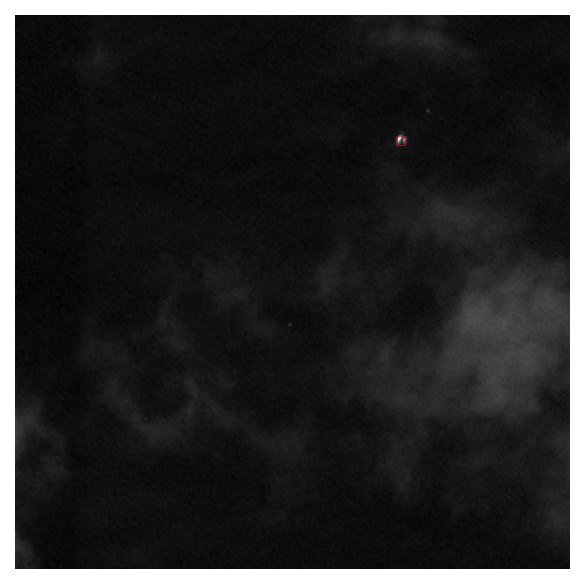

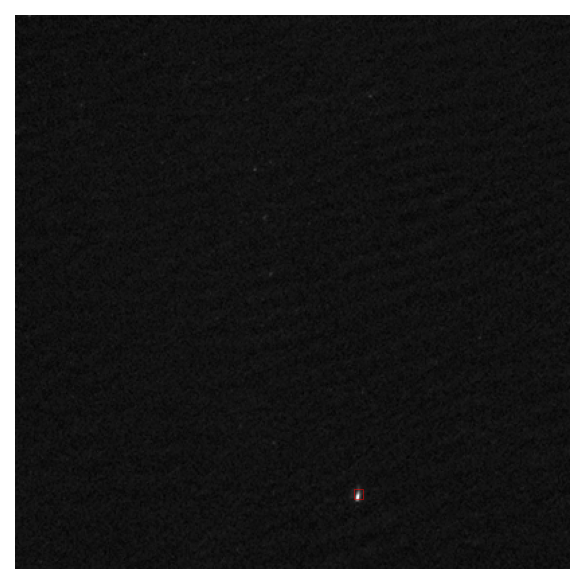

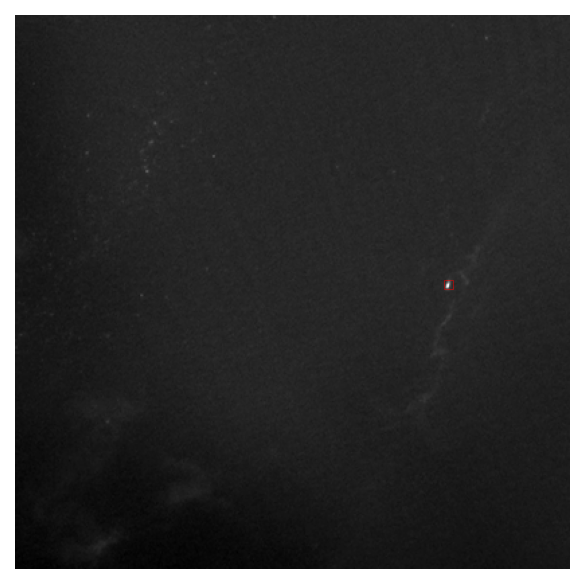

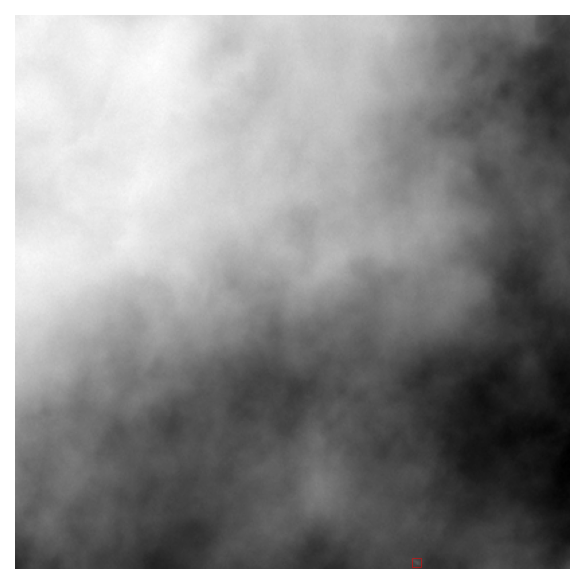

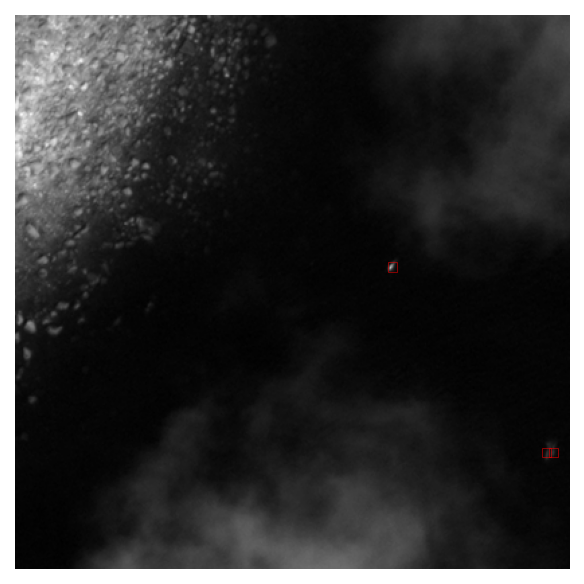

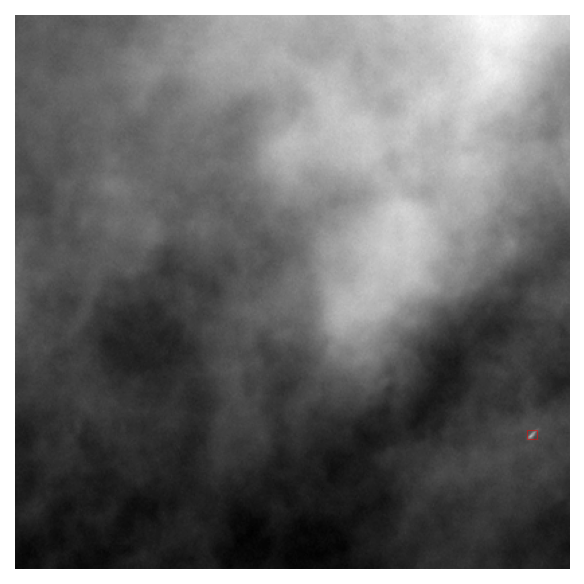

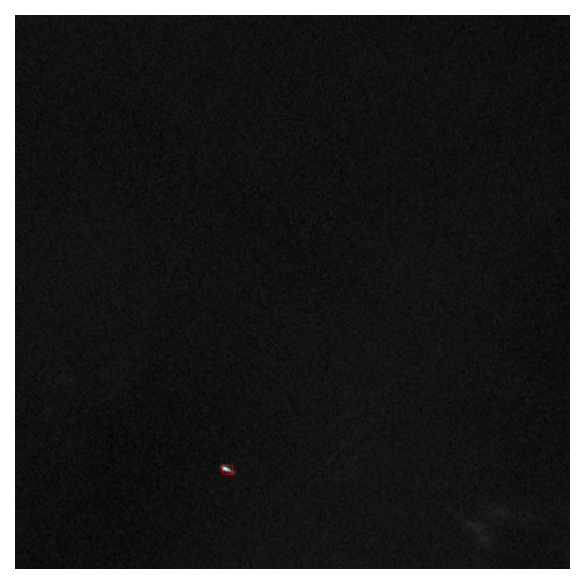

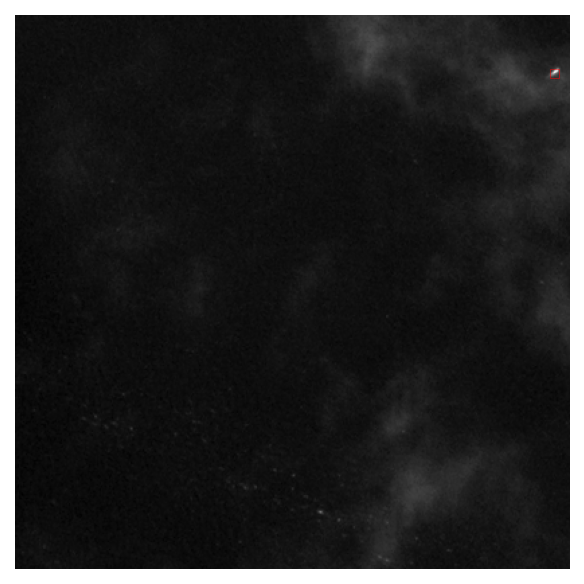

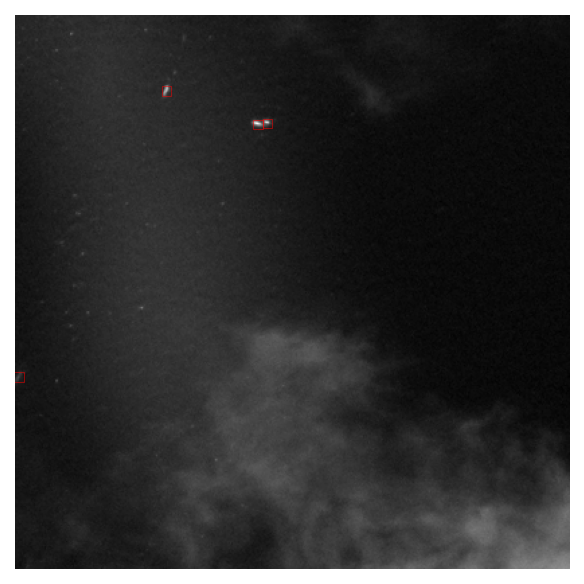

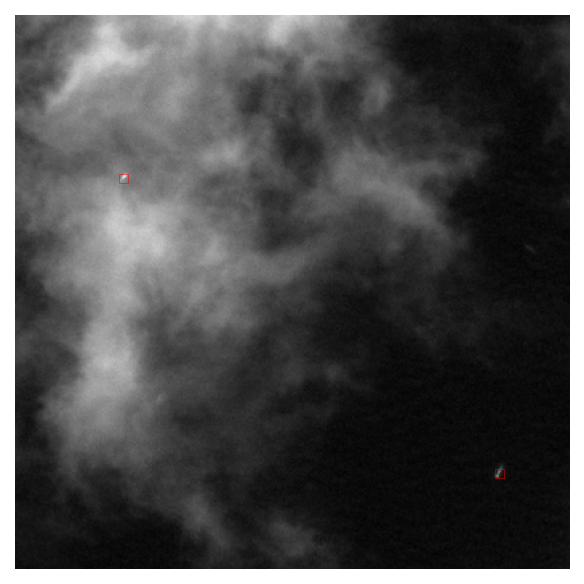

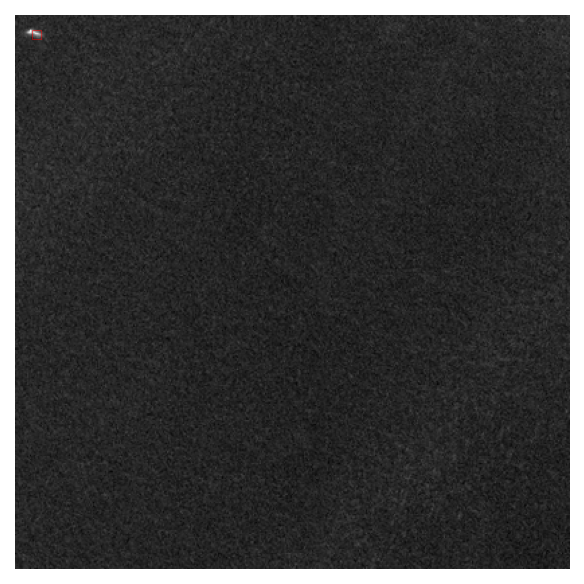

In [3]:
import random

for image in annotation['images']:
    if random.random() > 0.05:
        continue
    filename = image['file_name']
    bboxes = get_gt_box(filename)
    # Load the image using OpenCV
    img_path = os.path.join(img_dir, filename)
    img = cv2.imread(img_path)
    draw_bbox(img, bboxes)